# Networks Project


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import Counter
from logbin230119 import logbin
import pandas as pd
from scipy import stats

print("pandas version:",pd.__version__)
print("expect pandas version: > 0.25.0")

pandas version: 0.25.1
expect pandas version: > 0.25.0


pandas version must be 0.25.0 or above, if not, please update your pandas.

Else the code below would not work

In [3]:
# Generalize report format
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13,8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
def fit_log(x,y,plot = True,label = None):
    """
    Input un-logged raw x-y data, returns gradient and intercept
    """
    
    m,c,a,a,a = stats.linregress(np.log10(x),np.log10(y))
    
    if plot == True:
        samp_x = np.arange(min(x),max(x),1)
        plt.loglog(samp_x,samp_x**m * 10 **c,label = label)
    return m,c

## 1. Barabasi-Albert Model

Add exception error to prevent m > m0

Used a preferential list. Makes a list of of the every edge connection to a vertex. Having a larger number of these causes it to have a higher probability across the whole list. 

In [5]:
class Barabasi_Albert():

    def __init__(self, time_limit, m, m_start=None):
        """
        time_limit: run time until this value
        m: number edges to add every time a new vertex is added
        m0: int, set up initial graph.
        """

        if m_start == None:
            m_start = m
        G0 = nx.complete_graph(m_start)  # Start with complete graph, so that unbiased

        flatten = lambda l: [item for sublist in l for item in sublist]
        self.m0 = m_start
        self.m = m
        self.G = G0
        self.preferential_list = flatten([[x] * (m_start - 1) for x in range(m_start)])
        #         print(self.preferential_list)
        self.time_limit = time_limit

        if self.m > m_start:
            raise ValueError("m value must be less than initial graph value")

    def drive_pref(self,draw = False):
        for t in range(self.time_limit):
            node = t + self.m0  # Find the node number

            connections = []
            vertices = [node]

            for i in range(self.m):
                vertex = random.choice(self.preferential_list)
                while vertex in vertices:
                    vertex = random.choice(self.preferential_list)
                vertices.append(vertex)

                link = (node, vertex)
                # Save nodes to connect on graph
                connections.append(link)

                # Add to preferential list, one by one if m > 1. add last to prevent self-loops
                self.preferential_list.extend(link)

            if draw == True:
                self.G.add_node(node)
                self.G.add_edges_from(connections)

        df = self._get_counts()
        return df

    #             print(connections)

    def drive_random(self,draw = False):
        nodes = list(self.G.nodes)

        for t in range(self.time_limit):
            node = t + self.m0  # Find the node number
            nodes.append(node)
            connections = []
            vertices = [node]

            for i in range(self.m):
                vertex = random.choice(nodes)
                # Prevents multi loops
                while vertex in vertices:
                    vertex = random.choice(nodes)
                vertices.append(vertex)

                link = (node, vertex)
                # Save nodes to connect on graph
                connections.append(link)

                # Add to preferential list, one by one if m > 1. add last to prevent self-loops
                self.preferential_list.extend(link)
            if draw == True:

                self.G.add_node(node)
                self.G.add_edges_from(connections)

        df = self._get_counts()
        return df

    def drive_walk(self, q,draw = False):

        self.q = q
        
        if q == 1:
            raise ValueError("q must be less than 1")

        # Create list neighbours from a complete graph
        self.neighbours = [[x for x in range(self.m0) if x != i] for i in range(self.m0)]

        # Get list of nodes
        nodes = list(self.G.nodes)

        for t in range(self.time_limit):
            node = t + self.m0  # Find the node number
            connections = []  # Empty List for to list all connections required
            self.neighbours.append([])  # Append empty list for new node
            disallowed_vertices = [node]
            
            nodes.append(node)

            for i in range(self.m):

                # Pick an initial vertex
                vertex = random.choice(nodes)  # Can't pick itself, as not aded to the list yet

                # Prevents node from selecting the same vertex as run before from m=0,1,...
                while vertex in disallowed_vertices:
                    vertex = random.choice(nodes)

                # Continue walking with a probability of q
                while q > random.uniform(0, 1):
#                     print("Node = ",node,"Vertex = ",vertex,self.neighbours[vertex],"disallowed",disallowed_vertices)
                    
                    # Choose a neighbour of the target vertex.
                    vertex = random.choice(self.neighbours[vertex])

                    # Prevents self loops
                    while vertex in disallowed_vertices:
                        vertex = random.choice(self.neighbours[vertex])
                disallowed_vertices.append(vertex)

#                 print("Node = ",node,"Vertex = ",vertex,self.neighbours[vertex],"disallowed",disallowed_vertices)

                # Save vertices connected to, used to prevent multi links

                # Create tuple to connect nodes
                link = (node, vertex)

                # Save neighbours, in an adjacency list.
                self.neighbours[node].append(vertex)
                self.neighbours[vertex].append(node)

                # Save nodes to connect on graph
                connections.append(link)
                
            if draw == True:
                self.G.add_node(node)
                self.G.add_edges_from(connections)

        df = pd.DataFrame({"Node":nodes,"Degrees":[len(n) for n in self.neighbours]})
        df = df.set_index('Node')

        return df

    def get_degrees(self):
        return np.array(self.preferential_list)

    def _get_counts(self):
        counts = dict(Counter(self.preferential_list))

        df = pd.DataFrame(counts.items(), columns=['Node', 'Degrees'])
        df = df.set_index('Node')
        return df

    def draw(self):
        nx.draw(self.G, with_labels=True)#, font_weight='bold')
    def draw_knuth(self,scale = 1):
#         pos = nx.spring_layout(self.G)
        pos = nx.fruchterman_reingold_layout(self.G)

        nx.draw(self.G, pos,
        node_size=np.array([self.G.degree(v) for v in self.G]) * scale,
        node_color=[self.G.degree(v) for v in self.G],
        with_labels=False)


For q ~ 1, will walk randomly for longer, more likley to end up with a node with larger degrees and just has more paths to it, should resemble preferential attachment.

## 2. Phase 1: Pure Preferential Attachement

### 2.1.4 Checks

check number of nodes, check number of edges, distrubution of probabilities??

Expect Number of nodes to be: $N_{\text{nodes}} = \text{time}+N_{\text{nodes}}(t=0)$

Expect Number of links to be: $N_{\text{links}} = \frac{1}{2} (m_0-1) m_0 + mt$

Expect Number in Preferential List: $N_{\text{pref}} = 2 \cdot \text{time} \cdot m + (m_0-1) m_0 = 2 \times N_{\text{links}} $

In [551]:
m0 = 2

plt.figure(figsize = (5,3))

Ba_test = Barabasi_Albert(time_limit = 10000,m = m0)
degrees = Ba_test.drive_pref(draw = False)

# Ba_test.draw()

preferential_list = Ba_test.get_degrees()
print("Number of Nodes: Expected {}, Obtained {}".format(len(np.unique(preferential_list)),m0+time))
print("Number of Links: Expected {} Obtained {}".format(0.5*(m0-1)*m0+(time*m_test),len(preferential_list)/2))
print("Number of Preferentials: Expected {}, Obtained {}".format(2*(time*m_test)+(m0-1)*m0,len(preferential_list)))
print ("Mean of degree: Expected {}, Obtained {:.4f}".format(2*m0,np.mean(degrees.values)))


Number of Nodes: Expected 10002, Obtained 100002
Number of Links: Expected 200001.0 Obtained 20001.0
Number of Preferentials: Expected 400002, Obtained 40002
Mean of degree: Expected 4, Obtained 3.9994


<Figure size 360x216 with 0 Axes>

### 2.2.1 Expected Degree Distribution

Derive from the problem sheet

$$p_{\infty}(k)=\frac{2m(m+1)}{k(k+1)(k+2)}$$

In [7]:
repeats = 10

m_add = 2
m_test = [2,4,8,16,32,64,128]
# m_test = [2,4,8,16,32]#64,128]


time = 100000
times = [10,100,1000,10000,100000,1000000]
times_label = ['$10^1$','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$']

In [6]:
def master_EQ_pref(m,k,color=None,plot = True,label = True):
    
    p = (2*m*(m+1))/(k*(k+1)*(k+2))
    
    if plot == True:
        if label == True:
            plt.plot(k,p,'--',label = r"$p_{\infty}(k,m = {})=\frac{2m(m+1)}{k(k+1)(k+2)}$",color = color)
            
        else:
            plt.plot(k,p,'--',color = color)
    return p

def master_EQ_pref_cont(m,k,color=None,plot = True,label = True):
#     samp_x = np.arange(min(k),max(k))
    
    p = (2*m*(m+1))*k**(-3)
    
    if plot == True:
        if label == True:
            plt.plot(k,p,'-',label = r"$p_{\infty}(k)=\frac{2m(m+1)}{k(k+1)(k+2)}$",color = color)
        else:
            plt.plot(k,p,'-',color = color)
    return p

You should check that your solution obeys all
known theoretical constraints on the degree distribution

### 2.3.2 Degree Distribution

In [597]:
counts = []
xs = []
ys = []
stds_all = []
degrees_pref = []
for m_i in range(len(m_test)):
    print("m = ",m_test[m_i])
    degrees = []
    
    dicts = []

    for i in range(repeats):
        B = Barabasi_Albert(time_limit = time,m = m_test[m_i])
        df = B.drive_pref()
        degrees.extend(df.Degrees)
        x,y = logbin(df.Degrees,scale = 1.2,all_values = True)

        d = dict(zip(x,y))
        dicts.append(d)
    numbers = [len(d) for d in dicts]
    big_dict = dicts[np.argmax(numbers)]
    dicts.pop(np.argmax(numbers))

    d0 = {key: [value] for key,value in big_dict.items()}
    for key, value in d0.items():
        for i in range(len(dicts)):
            if key in dicts[i].keys():
                value.append(dicts[i][key])
            else:
                value.append(0)
    stds = np.array([np.std(s)/np.sqrt(repeats) for s in d0.values()])
    
    x,y = logbin(degrees,scale = 1.2,all_values = True)
#     x = x[1:]
#     y = y[1:]
#     stds = stds[1:]
    degrees_pref.append(degrees)
    xs.append(x)
    ys.append(y)
    stds_all.append(stds)
# print(len(x),len(stds))
xs_short = [xs[i][ys[i] !=0]for i in range(len(xs))]
ys_short = [ys[i][ys[i] !=0]for i in range(len(xs))]
stds_all_short = [stds_all[i][ys[i] !=0]for i in range(len(xs))]


m =  2
m =  4
m =  8
m =  16
m =  32
m =  64
m =  128


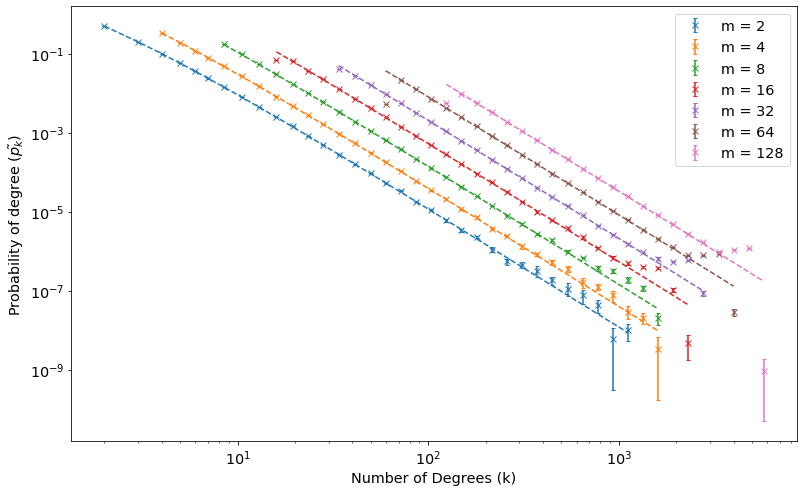

In [622]:
# Start plot where probability is non-zero.
# xs_short = [np.array([a for a in xs[i] if a >= m_test[i]]) for i in range(len(m_test))]
# sizes = [len(x) for x in xs_short]
# ys_short = [ys[i][-sizes[i]-1:] for i in range(len(ys))]
# stds_all_short = [stds_all[i][-sizes[i]-1:] for i in range(len(stds_all))]


for i in range(len(m_test)):
    plt.errorbar(xs_short[i],ys_short[i],fmt = 'x',yerr = stds_all_short[i],color = "C{}".format(i),
                 label = "m = {}".format(m_test[i]),capsize = 2)
    master_EQ_pref(m=m_test[i],k=xs_short[i], label = False,color = "C{}".format(i))
#     master_EQ_pref_cont(m=m_test[i],k=xs[i], label = False,color = "C{}".format(i))

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Degrees (k)")
plt.ylabel(r"Probability of degree ($\tilde{p_k})$")
plt.legend()

### 2.3.3. Statistics

#### K-S Test

$\textbf{Null Hypothesis:}$ Function is the same

$$D_{n, m}=\sup _{x}\left|F_{1, n}(x)-F_{2, m}(x)\right|$$
Reject null hypothesis with confidence $\alpha$ if $$D_{n, m}>c(\alpha) \sqrt{\frac{n+m}{n \cdot m}}$$

$$\begin{array}{|l|l|l|l|l|l|l|l|l|}
\hline \alpha & 0.20 & 0.15 & 0.10 & 0.05 & 0.025 & 0.01 & 0.005 & 0.001 \\
\hline c(\alpha) & 1.073 & 1.138 & 1.224 & 1.358 & 1.48 & 1.628 & 1.731 & 1.949 \\
\hline
\end{array}$$

* We find that D is much less tha expected threshold to reject the null hypothesis, so it is the same function and follows the expected probability distribution
* WE use KS as chi square if all the points are similar except one, this wouldn't be show a point standing out. Using KS, you can see how one point is far

In [8]:
def threshold(n,m,a):
    D = 1/np.sqrt(n) * np.sqrt(-np.log(a/2) * (1+n/m)/2)
    return D

#### KS-Test (Preferential)


In [598]:
a = 0.05

ths_avg = []
ths_avg_2 = []
D_avg = []
for i in range(len(xs_short)):
    print("m = ",m_test[i])

    CDF = np.cumsum(ys_short[i])
    CDF_expected = np.cumsum(master_EQ_pref(m=m_test[i],k=xs_short[i],plot = False))
    
#     plt.step(xs_short[i],CDF,'--',color = "C{}".format(i))
#     plt.step(xs_short[i],CDF_expected,color = "C{}".format(i))

#     print(stats.ks_2samp(ys_short[i],master_EQ_pref(m=m,k=xs_short[i],plot = False)))

    D = max(abs(CDF-CDF_expected))
    th = threshold(len(degrees_pref[i]),len(degrees_pref[i]),a = a)
#     th2= threshold(len(degrees_pref[i]),len(degrees_pref[i]),a = 0.20)
    D_avg.append(D)
    ths_avg.append(th)
    ths_avg_2.append(th2)
    
# print(D_avg,th)
D_df_3 = pd.DataFrame({"m":m_test,"D":D_avg,"th":ths_avg})#,"th2":ths_avg_2})    
D_df_3['del'] = D_df_3.D - D_df_3.th

# D_df_3.columns = ["$m$","$D_{n,l}$",r"Thresholds ($\alpha =$ {})".format(a),r"Thresholds ($\alpha =$ {})".format(0.1),"$\Delta$"]
D_df_3.columns = ["$m$","$D_{n,l}$",r"Thresholds ($\alpha =$ {})".format(a),"$\Delta$"]

D_df_3

m =  2
m =  4
m =  8
m =  16
m =  32
m =  64
m =  128


$m$  $D_{n,l}$  Thresholds ($\alpha =$ 0.05)  $\Delta$
0    2   0.000344                      0.001921 -0.001576
1    4   0.001257                      0.001921 -0.000663
2    8   0.004002                      0.001921  0.002081
3   16   0.043532                      0.001920  0.041611
4   32   0.008820                      0.001920  0.006900
5   64   0.031682                      0.001920  0.029762
6  128   0.011195                      0.001919  0.009275

In [571]:
x_,observed_values = logbin(df.Degrees,scale = 1.0)
expected_values = master_EQ_pref(m=2,k=x_,plot= False)
print(len(observed_values),len(expected_values))

stats.chisquare(f_obs = observed_values,f_exp = expected_values)

793 793


Power_divergenceResult(statistic=181.8196953802204, pvalue=1.0)

* a small p value means that you reject the null hypothesis, a high p value means you accept the null hypothesis

* for scipy.stats.chisquare - "The chi square test tests the null hypothesis that the categorical data has the given frequencies."

* so the null hypothesis is that the values fit

* so in this case, a high p value means that your fit is very good

* p > 0.95 to indicate very unlikely to be due to randomness

Doyou expect a perfect fit for all value of degree k?


What problems does the fat-tail of this distribution cause? Try to find a way to improve the problems caused by the fat tail

### 2.4.2 Preferential Largest Degree
Justify choice for m

* Ran on repeats of 5 times, so appended over 5 lists to improved statistics. 
* Min $k = m 

For large m, logbinning scale will become too small. Find a compromise to avoid the bump



In [191]:
times = [10,100,1000,10000,100000,1000000]
repeats = 100
m_add = 2


k_maxes = []
degrees_all = []

xs_2 = []
ys_2 = []

stds_all_2 = []

for i in range(len(times)):
    print("Calulating time t = ",times[i])
    degrees_total = []
    k_maxes.append([])
    
    dicts = []
    for N in range(repeats):
        Ba_1 = Barabasi_Albert(time_limit = times[i],m = m_add)
        df = Ba_1.drive_pref()
        
        degrees_total.extend(df.Degrees.values)
        k_maxes[i].append(max(df.Degrees.values))
        
        x,y = logbin(df.Degrees,scale = 1.2,all_values = True)

        d = dict(zip(x,y))
        dicts.append(d)
    
    sizes = [len(d) for d in dicts]
    big_dict = dicts[np.argmax(sizes)]
    dicts.pop(np.argmax(sizes))
    d0 = {key: [value] for key,value in big_dict.items()}

    for key, value in d0.items():
        for i in range(len(dicts)):
            if key in dicts[i].keys():
                value.append(dicts[i][key])
            else:
                value.append(0)
    stds = [np.std(s)/np.sqrt(repeats) for s in d0.values()]
    x,y = logbin(degrees_total,scale = 1.2,all_values = True)
    xs_2.append(x)
    ys_2.append(y)
    degrees_all.append(degrees_total)
    stds_all_2.append(stds)
xs_2 = [x[m_add-1:] for x in xs_2]
ys_2 = [y[m_add-1:] for y in ys_2]
stds_all_2 = [s[m_add-1:]for s in stds_all_2]

Calulating time t =  10
Calulating time t =  100
Calulating time t =  1000
Calulating time t =  10000
Calulating time t =  100000
Calulating time t =  1000000


Text(0, 0.5, 'Probability of degree ($\\tilde{p_k})$')

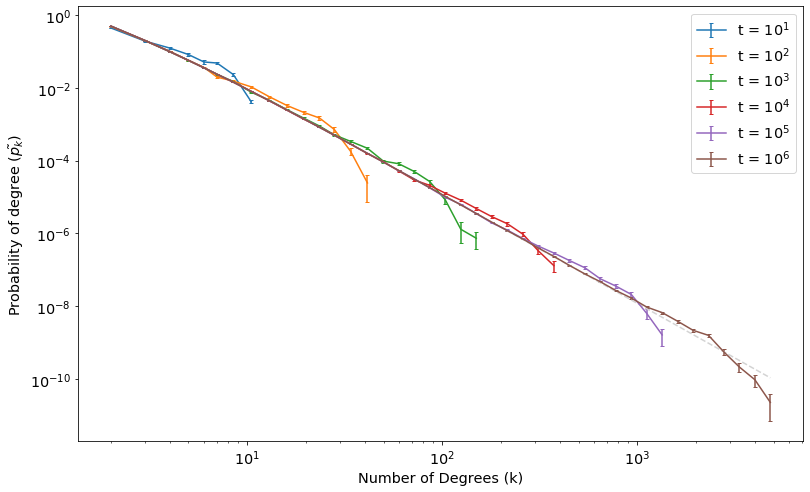

In [623]:
for i in range(len(times)):
    plt.errorbar(xs_2[i],ys_2[i],yerr = stds_all_2[i],label = "t = {}".format(times_label[i]),color = "C{}".format(i),
                capsize = 2)
plt.xscale('log')
plt.yscale('log')
master_EQ_pref(m=m_add,k=xs_2[i], label = False,color = "lightgray")
plt.legend()
plt.xlabel("Number of Degrees (k)")
plt.ylabel(r"Probability of degree ($\tilde{p_k})$")


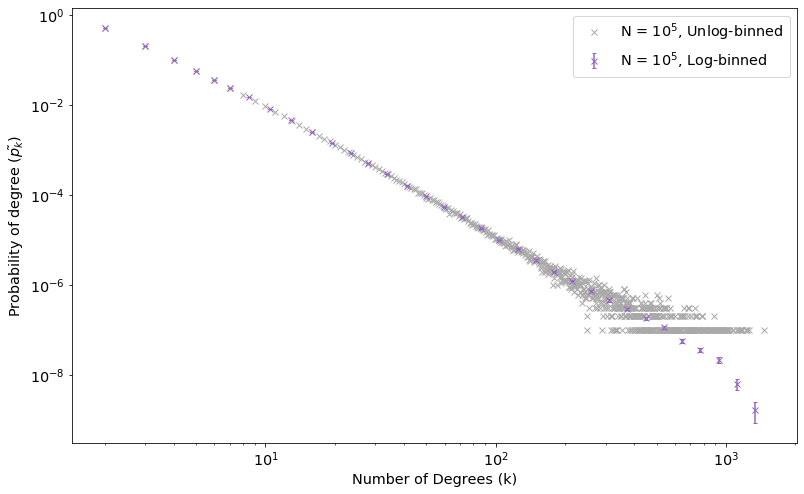

In [625]:
idx = 2
test_x,test_y = logbin(degrees_all[-idx],scale = 1.0)
x0,y0 = logbin(degrees_all[-idx],scale = 1.2)

plt.plot(test_x,test_y,'x',color = "darkgrey",label = "N = {}, Unlog-binned ".format(times_label[-idx]))
plt.errorbar(x0,y0,fmt = 'x',yerr = stds_all_2[-idx],label = "N = {}, Log-binned ".format(times_label[-idx]),color = "C{}".format(i-idx + 1),
            capsize = 2)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Number of Degrees (k)")
plt.ylabel(r"Probability of degree ($\tilde{p_k})$")
plt.legend()

Plot max degrees against time

CONTINUOUS
$$ k_{\max }=k_{\min } N^{\frac{1}{\gamma-1}}= mN^{\frac{1}{\gamma-1}} \\(\gamma = 3)$$

DISCRETE
$$
k_{1}=-\frac{1}{2}+\frac{\sqrt{1+4 N m(m+1)}}{2}
$$
Expect: 
https://www.wolframalpha.com/input/?i=sum+from+k%3Da+to+infinity+%28%282m%28m%2B1%29%29%2F%28k%28k%2B1%29%28k%2B2%29%29%29

In [192]:
def expected_k_max_pref(m,N):
    k1 = -0.5 + np.sqrt(1+4*N*m*(m+1))/2
    return k1

def expected_k_max_pref_cont(k_min,N):
    gamma = 3
    return k_min*N**(1/(gamma-1))

[0.11346805717910217, 0.49085231994969736, 1.7267712645281077, 6.226176595632348, 18.441785678182036, 53.59284276841451]


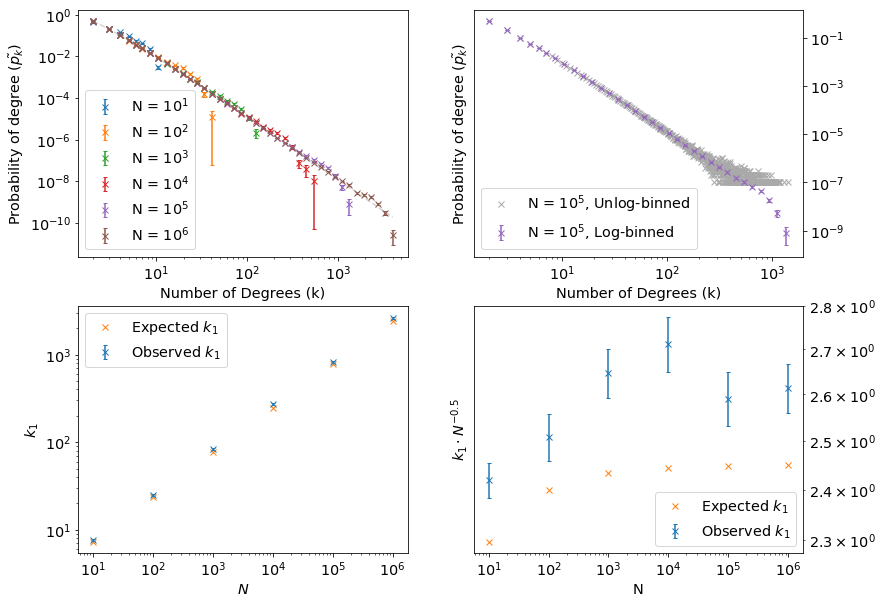

In [194]:
k_max_std = [np.std(k)/ np.sqrt(len(k)) for k in k_maxes] 
print(k_max_std)

max_degrees =[np.mean(x)for x in k_maxes]
idx = 1

k_discrete = expected_k_max_pref(m_add,np.array(times))

k_discrete_scaled = [k/np.sqrt(t) for k,t in zip(k_discrete,times)]
k_max_scaled = [k/np.sqrt(t) for k,t in zip(max_degrees,times)]
k_max_std_scaled = [k/np.sqrt(t) for k,t in zip(k_max_std,times)]

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (13,10))

for i in range(len(times)):
    ax1.errorbar(xs_2[i],ys_2[i],yerr = stds_all_2[i],fmt = 'x',label = "N = {}".format(times_label[i]),color = "C{}".format(i),
                capsize = 2)
p = master_EQ_pref(m=m_add,k=xs_2[i], label = False,color = "lightgray",plot = False)
ax1.plot(xs_2[i],p,'--',color = 'lightgray')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel("Number of Degrees (k)")
ax1.set_ylabel(r"Probability of degree ($\tilde{p_k})$")

idx = 2
test_x,test_y = logbin(degrees_all[-idx],scale = 1.0)
x0,y0 = logbin(degrees_all[-idx],scale = 1.2)
ax2.plot(test_x,test_y,'x',color = "darkgrey",label = "N = {}, Unlog-binned ".format(times_label[-idx]))
ax2.errorbar(x0,y0,fmt = 'x',yerr = stds_all_2[-idx],label = "N = {}, Log-binned ".format(times_label[-idx]),color = "C{}".format(i-idx + 1),
            capsize = 2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Number of Degrees (k)")
ax2.set_ylabel(r"Probability of degree ($\tilde{p_k})$")
ax2.legend()
ax2.yaxis.tick_right()

ax3.errorbar(times,max_degrees,yerr=k_max_std,fmt='x',label ="Observed $k_1$",capsize = 2)
ax3.loglog(times,k_discrete,'x',label = "Expected $k_1$")
ax3.set_xlabel("$N$")
ax3.set_ylabel("$k_1$")
ax3.legend()

ax4.errorbar(times,k_max_scaled,fmt = 'x',yerr = k_max_std_scaled,label = "Observed $k_1$",
            capsize = 2)
ax4.loglog(times,k_discrete_scaled,'x',label = "Expected $k_1$")
ax4.set_xlabel("N")
ax4.set_ylabel(r"$k_1 \cdot N^{-0.5}$")
ax4.yaxis.tick_right()
ax4.legend()

In [608]:
# fit_log(times,max_degrees)
stats.linregress(np.log10(times),np.log10(max_degrees))

LinregressResult(slope=0.5045725425407716, intercept=0.39629976084205265, rvalue=0.9999683845704266, pvalue=1.4992872802972436e-09, stderr=0.002006173352287905)

### 2.4.3 Data Collapse (Preferential)

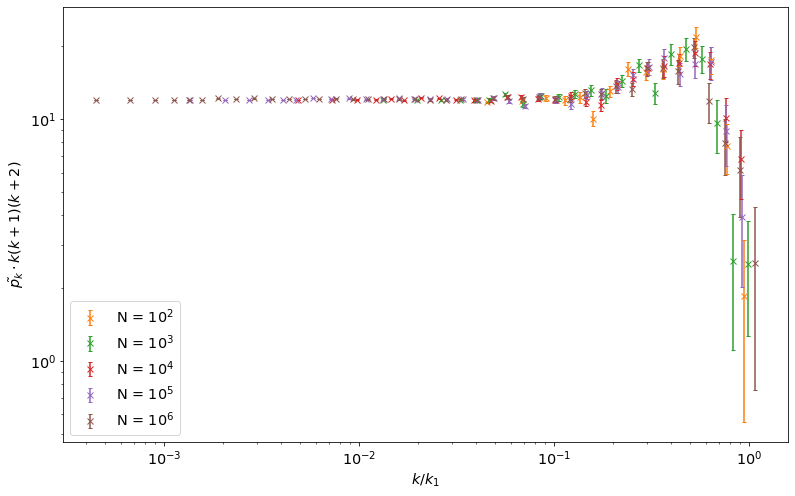

In [630]:
for i in range(1,len(xs_2)):
    y =ys_2[i] * xs_2[i]*(xs_2[i]+1)*(xs_2[i]+2)
    x = xs_2[i]/ max(degrees_all[i])
    s = stds_all_2[i]* xs_2[i]*(xs_2[i]+1)*(xs_2[i]+2)
    plt.errorbar(x,y,yerr = s,fmt = 'x',capsize = 2,label = "N = {}".format(times_label[i]),color = "C{}".format(i))
    
plt.xlabel("$k/k_{1}$")
plt.ylabel(r"$\tilde{p_k}\cdot k(k+1)(k+2)$")
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.1,50)
plt.legend()

## 3. Phase 2: Random Attachment

### 3.2.1 Degree Distribution Numerical Results

In [10]:
def master_EQ_random_continuous(k,m):
    p=np.exp(1)/m* np.exp(-k/m)
    return p

def master_EQ_random_discrete(k,m):
    p= (m/(m+1))**(k-m) * (1/(m+1))
    return p

In [609]:
m_test

[2, 4, 8, 16, 32, 64, 128]

In [610]:
counts = []
degrees_random = []
xs_3 = []
ys_3 = []
stds_all_3 = []
for m_i in range(len(m_test)):
    print("m = ",m_test[m_i])
    degrees = []
    
    dicts = []

    for i in range(repeats):
        B = Barabasi_Albert(time_limit = time,m = m_test[m_i])
        df = B.drive_random()
        
        #Save all degree values to do final logbin (repeats)
        degrees.extend(df.Degrees)
        
        # Save individual logbins for stds
        x,y = logbin(df.Degrees,scale = 1.0,all_values = True)
        d = dict(zip(x,y))
        dicts.append(d)
    
    degrees_random.append(degrees)
    # Find the biggest dict to use as x values
    numbers = [len(d) for d in dicts]
    big_dict = dicts[np.argmax(numbers)]
    # Remove biggest dict from list of dicts
    dicts.pop(np.argmax(numbers))

    # Save values into dictionary lists, to find std
    d0 = {key: [value] for key,value in big_dict.items()}
    for key, value in d0.items():
        for i in range(len(dicts)):
            if key in dicts[i].keys():
                value.append(dicts[i][key])
            else:
                value.append(0)
    # Find stds
    stds = [np.std(s)/np.sqrt(repeats) for s in d0.values()]
    x,y = logbin(degrees,scale = 1.0,all_values = True)

    # Find values that don't match
    bad_values = [a for a in x if a not in list(d0.keys())]
    indices = [np.where(x ==i) for i in bad_values]
    # Delete values that don't match with the biggest dictionary
    x = np.delete(x,indices)
    y = np.delete(y,indices)

    xs_3.append(x)
    ys_3.append(y)
    stds_all_3.append(stds)

m =  2
m =  4
m =  8
m =  16
m =  32
m =  64
m =  128


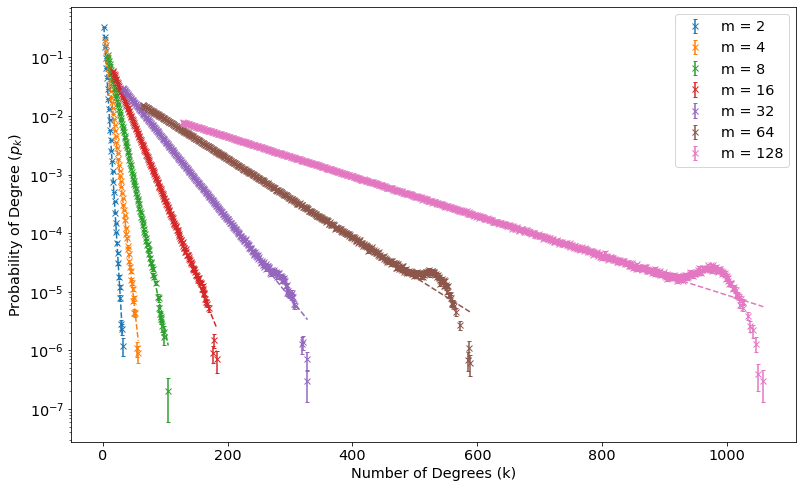

In [614]:
for i in range(len(xs_3)):
    plt.errorbar(xs_3[i],ys_3[i],fmt = 'x',yerr = stds_all_3[i],capsize = 2,label = "m = {}".format(m_test[i]),
                color = "C{}".format(i))
    plt.plot(xs_3[i],master_EQ_random_discrete(xs_3[i],m_test[i]),'--',color = "C{}".format(i))

plt.yscale('log')
plt.xlabel("Number of Degrees (k)")
plt.ylabel("Probability of Degree ($p_k$)")
plt.legend()

#### KS-Test (Random)

In [613]:
D_avg = []
ths_avg = []
a = 0.05
for j in range(len(xs_3)):
    print("m = ",m_test[j])

    CDF = np.cumsum(ys_3[j])
    CDF_expected = np.cumsum(master_EQ_random_discrete(m=m_test[j],k=xs_3[j]))
#     plt.step(xs_3[j],CDF,color = "C{}".format(j))
#     plt.step(xs_3[j],CDF_expected,'--',color = "black".format(j),alpha = 0.5)
    D = (max(abs(CDF-CDF_expected)))
    th = threshold(len(degrees_random[j]),len(degrees_random[j]),a =a)
    
#     print(stats.ks_2samp(CDF,CDF_expected))

    D_avg.append(D)
    ths_avg.append(th)
D_df_2 = pd.DataFrame({"m":m_test,"D":D_avg,"th".format(a):ths_avg})    
D_df_2['del'] = D_df_2.D - D_df_2.th

D_df_2.columns = ["$m$","$D_{n,l}$",r"Thresholds ($\alpha =$ {})".format(a),"$\Delta$"]
D_df_2

m =  2
m =  4
m =  8
m =  16
m =  32
m =  64
m =  128


$m$  $D_{n,l}$  Thresholds ($\alpha =$ 0.05)  $\Delta$
0    2   0.000186                      0.000607 -0.000421
1    4   0.000148                      0.000607 -0.000459
2    8   0.000142                      0.000607 -0.000465
3   16   0.000092                      0.000607 -0.000515
4   32   0.000147                      0.000607 -0.000461
5   64   0.000353                      0.000607 -0.000254
6  128   0.000792                      0.000607  0.000185

### 3.2.2 Largest Degree Numerical Results (Random)

https://www.wolframalpha.com/input/?i=sum+from+k%3Da+to+infinity+%28%281%2F%28m%2B1%29%29%28m%2F%28m%2B1%29%29**%28k-m%29%29

DISCRETE
$$
k_{1}=\frac{\log \left|\left(\frac{m}{m+1}\right)^{m} \cdot \frac{1}{N}\right|}{\log \left|\frac{m}{m+1}\right|}
$$

In [11]:
def expected_k_max_random(m,N):
    y = np.log10((m/(m+1))**m * 1/N)/(np.log10(m/(m+1)))
    return y

In [632]:
counts = []
k_maxes_random = []

xs_4 = []
ys_4 = []
stds_all_4 = []

repeats = 100
for t in range(len(times)):
    print("t = ",times[t])
    degrees = []
    
    dicts = []
    k_maxes_random.append([])

    for i in range(repeats):
        B = Barabasi_Albert(time_limit = times[t],m = m_add)
        df = B.drive_random()
        
        #Save all degree values to do final logbin (repeats)
        degrees.extend(df.Degrees)
        
        # Save individual logbins for stds
        x,y = logbin(df.Degrees,scale = 1.0,all_values = True)
        d = dict(zip(x,y))
        dicts.append(d)
        
        k_maxes_random[t].append(max(df.Degrees.values))
        
    # Find the biggest dict to use as x values
    numbers = [len(d) for d in dicts]
    big_dict = dicts[np.argmax(numbers)]
    # Remove biggest dict from list of dicts
    dicts.pop(np.argmax(numbers))

    # Save values into dictionary lists, to find std
    d0 = {key: [value] for key,value in big_dict.items()}
    for key, value in d0.items():
        for i in range(len(dicts)):
            if key in dicts[i].keys():
                value.append(dicts[i][key])
            else:
                value.append(0)
    # Find stds
    stds = [np.std(s)/np.sqrt(repeats) for s in d0.values()]
    x,y = logbin(degrees,scale = 1.0,all_values = True)

    # Find values that don't match
    bad_values = [a for a in x if a not in list(d0.keys())]
    indices = [np.where(x ==i) for i in bad_values]
    # Delete values that don't match with the biggest dictionary
    x = np.delete(x,indices)
    y = np.delete(y,indices)

    xs_4.append(x)
    ys_4.append(y)
    stds_all_4.append(stds)

t =  10
t =  100
t =  1000
t =  10000
t =  100000
t =  1000000


Text(0, 0.5, 'Probability of Degree ($p_k$)')

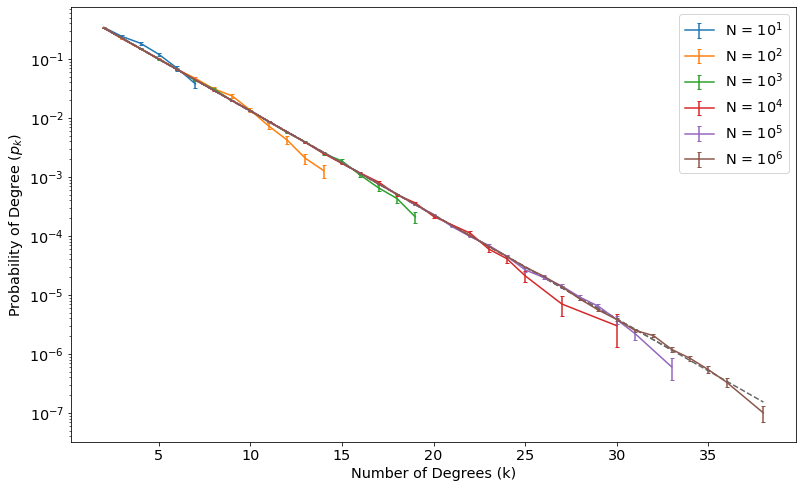

In [637]:
for i in range(len(times)):
    plt.errorbar(xs_4[i],ys_4[i],
                 yerr = stds_all_4[i],label = "N = {}".format(times_label[i]),color = "C{}".format(i),
                capsize = 2)
    plt.plot(xs_4[i],master_EQ_random_discrete(xs_4[i],m_add),'--',color = "dimgray")

# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Number of Degrees (k)")
plt.ylabel("Probability of Degree ($p_k$)")

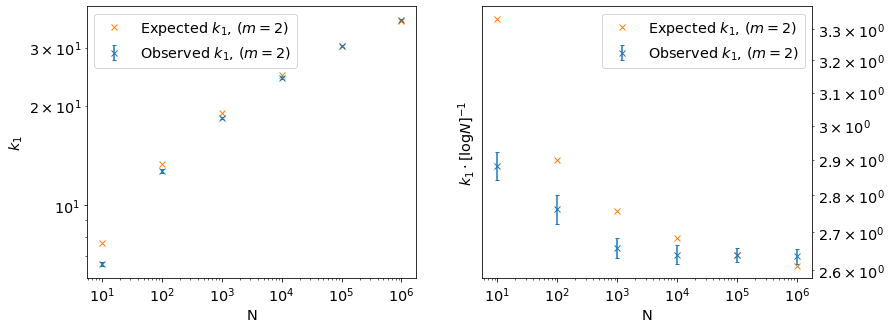

In [638]:
k_max_std = [np.std(k)/ np.sqrt(len(k)) for k in k_maxes_random] 
max_degrees =[np.mean(x)for x in k_maxes_random]
expected_values = expected_k_max_random(m_add,np.array(times))

k_max_scaled = max_degrees/np.log(times)
k_max_expected_scaled = expected_values/np.log(times)
k_max_std_scaled =[k/t for k,t in zip(k_max_std,np.log(times))]

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (13,5))

ax1.errorbar(times,max_degrees,fmt = 'x',yerr = k_max_std, label = "Observed $k_1$, $(m=2)$",
            capsize = 2)
ax1.plot(times,expected_values,'x',label = "Expected $k_1$, $(m=2)$")

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xlabel("N")
ax1.set_ylabel("$k_1$")
ax1.legend()

ax2.errorbar(times,k_max_scaled,fmt = 'x',yerr = k_max_std_scaled, label = "Observed $k_1$, $(m=2)$",
            capsize = 2)
ax2.plot(times,k_max_expected_scaled,'x',label = "Expected $k_1$, $(m=2)$")
ax2.yaxis.tick_right()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel("$k_1 \cdot[\logN]^{-1}$")
ax2.set_xlabel("N")
plt.legend()

## 4. Phase 3: Random Walk

### 4.2 Numerical Results

In [20]:
BA_1 = Barabasi_Albert(time_limit = 1000 , m=m_add)
df_1 = BA_1.drive_walk(q = 0.99)
x1,y1 = logbin(df_1.Degrees,scale = 1.2)

# BA_0 = Barabasi_Albert(time_limit = time , m=m_add)
# df_0 = BA_0.drive_walk(q = 0.0)
# x0,y0 = logbin(df_0.Degrees,scale = 1.0)


In [187]:
qs = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]

qs = [0,0.25,0.3,0.31,0.32,0.34,0.35,0.36,0.40,0.5,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8]
# qs = [0,0.25,0.3,0.40,0.41,0.42,0.43,0.44,0.5,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.99]
# 
# qs = [0.20,0.25,0.26,0.27,0.28,0.29]
# qs = [0,0.01,0.02,0.03,0.04,0.05,0.95,0.96,0.97,0.98,0.99]
# qs = [0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,]

time = 1000
N_runs = 1

xqs = []
yqs = []
degrees_qs = []
for q in qs:
    print("q = ",q)
    degrees = []
    for x in range(N_runs):
#         BA_q = Barabasi_Albert(time_limit = time , m=m_add)
        BA_q = Barabasi_Albert(time_limit = time, m=m_add)

        df_q = BA_q.drive_walk(q = q)
        degrees.extend(df_q.Degrees)
        
    degrees_qs.append(degrees)
    xq,yq = logbin(degrees,scale = 1.0)
    xqs.append(xq)
    yqs.append(yq)

q =  0
q =  0.25
q =  0.3
q =  0.31
q =  0.32
q =  0.34
q =  0.35
q =  0.36
q =  0.4
q =  0.5
q =  0.69
q =  0.7
q =  0.71
q =  0.72
q =  0.73
q =  0.74
q =  0.75
q =  0.76
q =  0.77
q =  0.78
q =  0.79
q =  0.8


#### Calculate Scaled Degree Distributions for different q


In [21]:
expected_values = master_EQ_pref(m=m_add,k=x1,color = "black",label = False,plot = False)
yq_scaled = [yqs[i]* xqs[i]*(xqs[i]+1)*(xqs[i]+2) for i in range(len(xqs))]
xq_scaled = [xqs[i]/(-0.5 + np.sqrt(time*m_add*(m_add+1)+0.25)) for i in range(len(xqs))]
# xq_scaled = [xqs[i]/max(xqs[i]) for i in range(len(xqs))]

y1_scaled = y1 * x1*(x1+1)*(x1+2)
x1_scaled = x1/(-0.5 + np.sqrt(time*m_add*(m_add+1)+0.25))#max(x1)#(-0.5 + np.sqrt(times[i]))
expected_scaled = expected_values * x1*(x1+1)*(x1+2)


(0.1, 100)

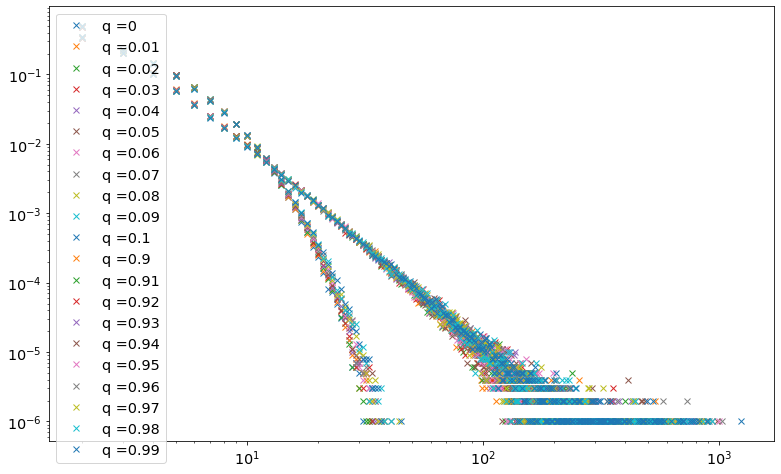

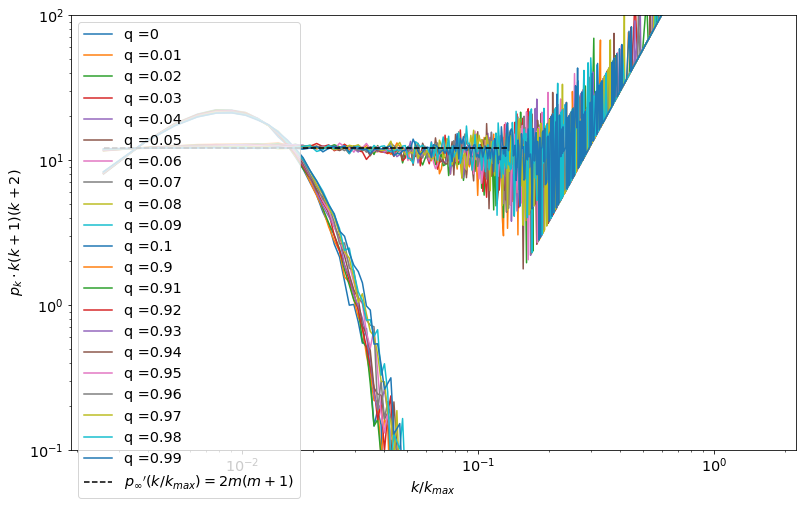

In [22]:
# plt.loglog(x0,y0,'x',label = "q =0")
# plt.loglog(x1,y1,'x',label = "q =0.99")

[plt.loglog(xqs[i],yqs[i],'x',label = "q ={}".format(qs[i])) for i in range(len(xqs))]
plt.legend()
plt.figure()
# [plt.step(xqs[i],np.cumsum(yqs[i]),label = "q ={}".format(qs[i])) for i in range(len(xqs))]

[plt.loglog(xq_scaled[i],yq_scaled[i],label = "q ={}".format(qs[i])) for i in range(len(xqs))]

# plt.loglog(x1_scaled,y1_scaled,'x',label = "q = 0.99")
plt.loglog(x1_scaled,expected_scaled,'--',label = r"${p_{\infty}}'(k/k_{max})={2m(m+1)}$",color = "black")

plt.xlabel("$k/k_{max}$")
plt.ylabel("$p_k \cdot k(k+1)(k+2)$")
plt.legend()

plt.ylim(0.1,100)

In [136]:
qs = [0,0.25,0.5,0.75,0.99]
repeats  = 10
counts = []
degrees_q = []
xs_5 = []
ys_5 = []
stds_all_5 = []
time = 100000
for i_q in range(len(qs)):
    print("q = ",qs[i_q])
    degrees = []
    
    dicts = []

    for i in range(repeats):
        B = Barabasi_Albert(time_limit = time,m = m_add)
        df = B.drive_walk(qs[i_q])
        
        #Save all degree values to do final logbin (repeats)
        degrees.extend(df.Degrees)
        
        # Save individual logbins for stds
        x,y = logbin(df.Degrees,scale = 1.0,all_values = True)
        d = dict(zip(x,y))
        dicts.append(d)
    
    degrees_q.append(degrees)
    # Find the biggest dict to use as x values
    numbers = [len(d) for d in dicts]
    big_dict = dicts[np.argmax(numbers)]
    # Remove biggest dict from list of dicts
    dicts.pop(np.argmax(numbers))

    # Save values into dictionary lists, to find std
    d0 = {key: [value] for key,value in big_dict.items()}
    for key, value in d0.items():
        for i in range(len(dicts)):
            if key in dicts[i].keys():
                value.append(dicts[i][key])
            else:
                value.append(0)
    # Find stds
    stds = [np.std(s)/np.sqrt(repeats) for s in d0.values()]
    x,y = logbin(degrees,scale = 1.0,all_values = True)

    # Find values that don't match
    bad_values = [a for a in x if a not in list(d0.keys())]
    indices = [np.where(x ==i) for i in bad_values]
    # Delete values that don't match with the biggest dictionary
    x = np.delete(x,indices)
    y = np.delete(y,indices)

    xs_5.append(x)
    ys_5.append(y)
    stds_all_5.append(stds)

q =  0
q =  0.25
q =  0.5
q =  0.75
q =  0.99


In [108]:
master_EQ_pref(xs_5[0],m_add,plot = False)

array([ 0.5       ,  1.        ,  1.66666667,  2.5       ,  3.5       ,
        4.66666667,  6.        ,  7.5       ,  9.16666667, 11.        ,
       13.        , 15.16666667, 17.5       , 20.        , 22.66666667,
       25.5       , 28.5       , 31.66666667, 35.        , 38.5       ,
       42.16666667, 46.        , 50.        , 54.16666667, 58.5       ,
       63.        , 67.66666667, 72.5       , 82.66666667])

In [114]:
xs_5[-1]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  96,  97,  98,  99, 100, 101, 102, 103, 105, 106, 108, 111,
       113, 114, 115, 116, 117, 118, 119, 121, 126, 128, 129, 130, 132,
       133, 134, 135, 138, 139, 145, 146, 149, 152, 153, 155, 157, 162,
       163, 165, 166, 174, 184, 197, 199, 203, 239, 263, 272, 273, 292,
       356, 383, 393, 490, 543, 596, 597])

Text(0, 0.5, 'Probability of degree ($\\tilde{p_k})$')

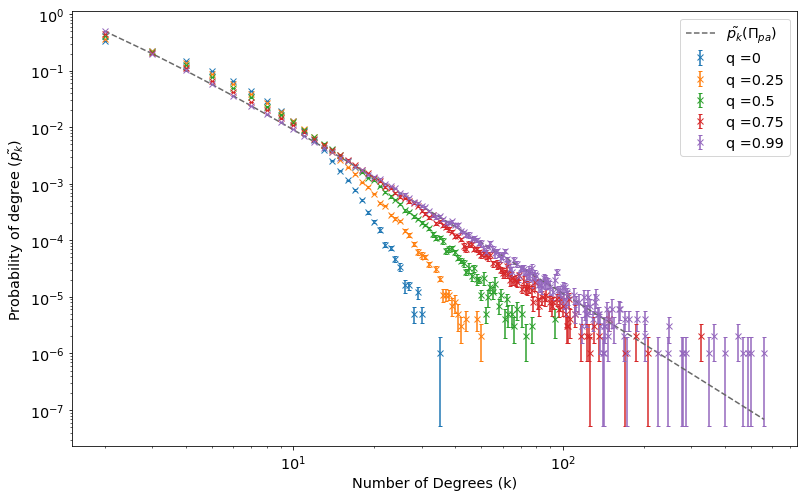

In [137]:
# plt.loglog(x0,y0,'x',label = "q =0")
# plt.loglog(x1,y1,'x',label = "q =0.99")

[plt.errorbar(xs_5[i],ys_5[i],fmt ='x',yerr = stds_all_5[i],label = "q ={}".format(qs[i]),
             capsize = 2) for i in range(len(xs_5))]
# master_EQ_pref(np.arange(m_add,600,1),m_add)
plt.loglog(xs_5[-1],master_EQ_pref(m_add,xs_5[-1],plot = False),'--',label = r"$\tilde{p_k} (\Pi_{pa})$",color = 'dimgray')

plt.legend()

plt.xlabel("Number of Degrees (k)")
plt.ylabel(r"Probability of degree ($\tilde{p_k})$")
# [plt.step(xqs[i],np.cumsum(yqs[i]),label = "q ={}".format(qs[i])) for i in range(len(xqs))]

# [plt.loglog(xq_scaled[i],yq_scaled[i],label = "q ={}".format(qs[i])) for i in range(len(xqs))]

# # plt.loglog(x1_scaled,y1_scaled,'x',label = "q = 0.99")
# plt.loglog(x1_scaled,expected_scaled,'--',label = r"${p_{\infty}}'(k/k_{max})={2m(m+1)}$",color = "black")

# plt.xlabel("$k/k_{max}$")
# plt.ylabel("$p_k \cdot k(k+1)(k+2)$")
# plt.legend()

# plt.ylim(0.1,100)

#### KS-Test (Random Walk)

In [188]:
D_avg_1 = []
ths_avg_1 = []
D_avg_2 = []
ths_avg_2 = []

a = 0.05
for j in range(len(xqs)):
#     print("q = ",qs[j])

    CDF = np.cumsum(yqs[j])
    CDF_expected = np.cumsum(master_EQ_pref(m=2,k=xqs[j],plot = False))
    CDF_expected_2 = np.cumsum(master_EQ_random_discrete(m=m_add,k=xqs[j]))
    
    D_1 = (max(abs(CDF-CDF_expected)))
    th_1 = threshold(len(degrees_qs[j]),len(degrees_qs[j]),a = a)
    
    D_2 = (max(abs(CDF-CDF_expected_2)))
    th_2 = threshold(len(degrees_qs[j]),len(degrees_qs[j]),a = a)
        
    D_avg_1.append(D_1)
    ths_avg_1.append(th_1)
    
    D_avg_2.append(D_2)
    ths_avg_2.append(th_2)

    
D_df_1 = pd.DataFrame({"q":qs,"D":D_avg_1,"th".format(a):ths_avg_1})    
D_df_1['del'] = D_df_1.D - D_df_1.th

D_df_1.columns = ["$q$","$D_{n,l}$",r"Thresholds ($\alpha =$ {})".format(a),"$\Delta$"]
D_df_1

D_df_4 = pd.DataFrame({"q":qs,"D":D_avg_2,"th".format(a):ths_avg_2})    
D_df_4['del'] = D_df_4.D - D_df_4.th

D_df_4.columns = ["$q$","$D_{n,l}$",r"Thresholds ($\alpha =$ {})".format(a),"$\Delta$"]
# D_df_4


# D_df_1 # Compared to Preferential
# D_df_1.to_csv("compared to preferential")

In [186]:
D_df_1.to_csv("compared_to_preferential.csv")
D_df_1

$q$  $D_{n,l}$  Thresholds ($\alpha =$ 0.05)  $\Delta$
0   0.00   0.163673                      0.060676  0.102997
1   0.25   0.114770                      0.060676  0.054095
2   0.30   0.135729                      0.060676  0.075053
3   0.40   0.113772                      0.060676  0.053097
4   0.41   0.091816                      0.060676  0.031141
5   0.42   0.116766                      0.060676  0.056091
6   0.43   0.116766                      0.060676  0.056091
7   0.44   0.112774                      0.060676  0.052099
8   0.50   0.096806                      0.060676  0.036131
9   0.69   0.044311                      0.060676 -0.016364
10  0.70   0.077844                      0.060676  0.017169
11  0.71   0.044311                      0.060676 -0.016364
12  0.72   0.059880                      0.060676 -0.000795
13  0.73   0.073852                      0.060676  0.013177
14  0.74   0.048902                      0.060676 -0.011773
15  0.75   0.067864                      0.060676  0.007189
16  0.76   0.035928                      0.060676 -0.024747
17  0.77   0.051297                      0.060676 -0.009378
18  0.78   0.039920                      0.060676 -0.020755
19  0.79   0.055888                      0.060676 -0.004787
20  0.80   0.044511                      0.060676 -0.016165
21  0.99   0.012974                      0.060676 -0.047701

In [189]:
D_df_1.to_csv("compared_to_random.csv")
D_df_4 # Compared to Random

$q$  $D_{n,l}$  Thresholds ($\alpha =$ 0.05)  $\Delta$
0   0.00   0.007984                      0.060676 -0.052691
1   0.25   0.028277                      0.060676 -0.032399
2   0.30   0.044245                      0.060676 -0.016431
3   0.31   0.060878                      0.060676  0.000203
4   0.32   0.045908                      0.060676 -0.014767
5   0.34   0.067864                      0.060676  0.007189
6   0.35   0.067864                      0.060676  0.007189
7   0.36   0.059215                      0.060676 -0.001461
8   0.40   0.055223                      0.060676 -0.005453
9   0.50   0.089820                      0.060676  0.029145
10  0.69   0.106786                      0.060676  0.046111
11  0.70   0.108117                      0.060676  0.047442
12  0.71   0.104790                      0.060676  0.044115
13  0.72   0.112774                      0.060676  0.052099
14  0.73   0.115768                      0.060676  0.055093
15  0.74   0.128743                      0.060676  0.068067
16  0.75   0.109780                      0.060676  0.049105
17  0.76   0.121756                      0.060676  0.061081
18  0.77   0.125749                      0.060676  0.065073
19  0.78   0.121756                      0.060676  0.061081
20  0.79   0.126747                      0.060676  0.066071
21  0.80   0.128743                      0.060676  0.068067

#### Test for Duplicates

In [11]:
BA = Barabasi_Albert(time_limit = 100000 , m=2)
df = BA.drive_walk(q = 0.5)

# BA.draw()
# print(BA.neighbours)
count = 0
for x in BA.neighbours:
    if len(x) != len(np.unique(x)):
        print(count,x)
        print(pd.DataFrame(BA.neighbours))

        raise ValueError("Duplicates in list of neighbours")
    count +=1
print("No duplicates in Neighbours")


No duplicates in Neighbours


### NetworkX Graphs for Visualisation

#### Random Attachment

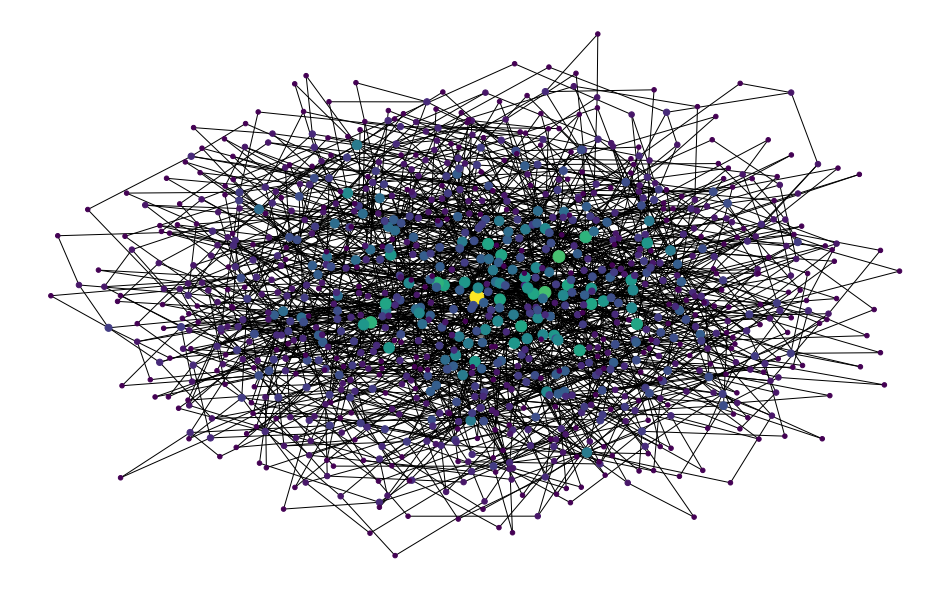

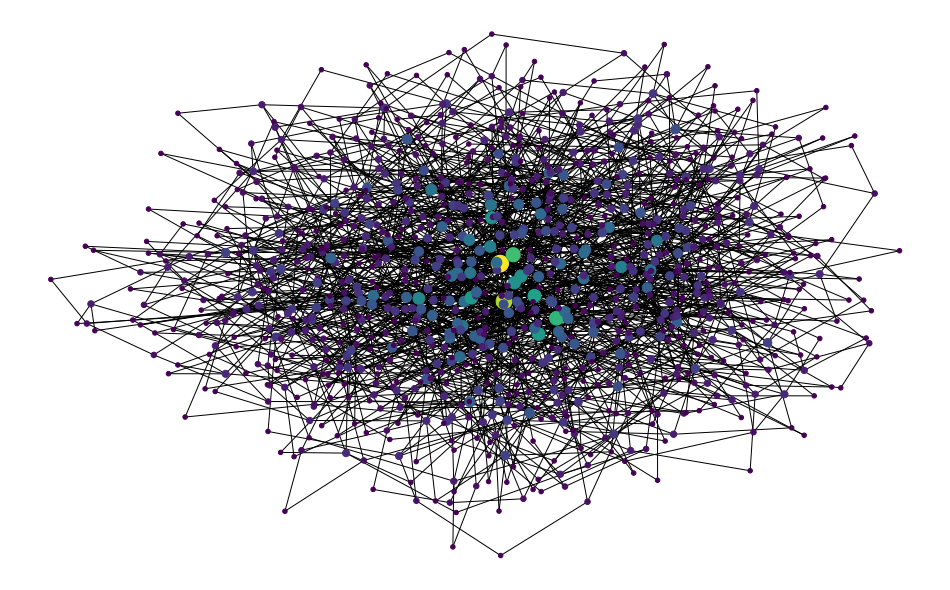

In [178]:
BA = Barabasi_Albert(time_limit = 1000 , m=2)
df = BA.drive_walk(q = 0.0,draw = True)
plt.figure(figsize = (13,8))
BA.draw_knuth(scale = 10)

BA = Barabasi_Albert(time_limit = 1000 , m=2)
df = BA.drive_walk(q = 0.34,draw = True)
plt.figure(figsize = (13,8))
BA.draw_knuth(scale = 10)

#### Preferential Attachment

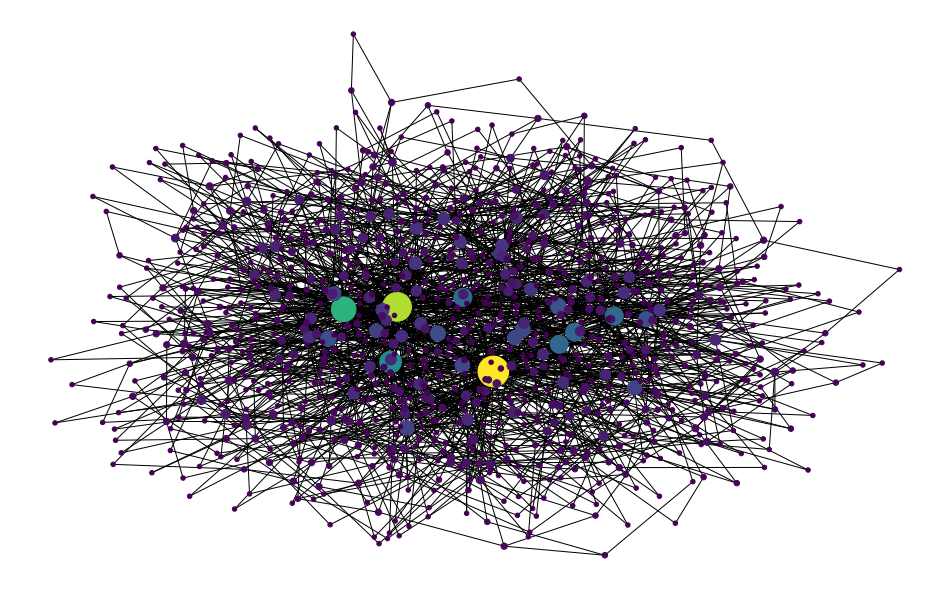

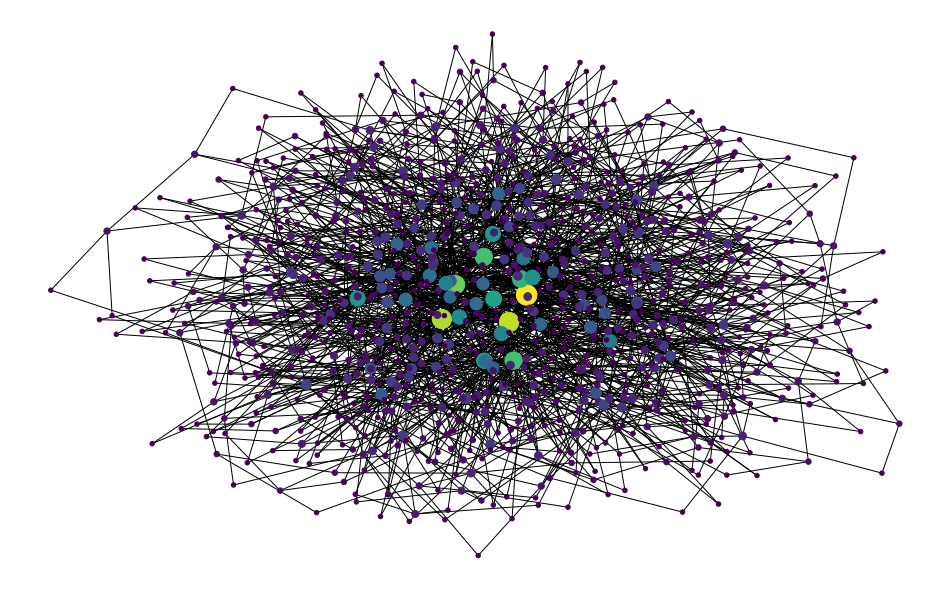

In [179]:
BA = Barabasi_Albert(time_limit = 1000 , m=2)
df = BA.drive_walk(q = 0.99,draw = True)
plt.figure(figsize = (13,8))
BA.draw_knuth(scale = 10)

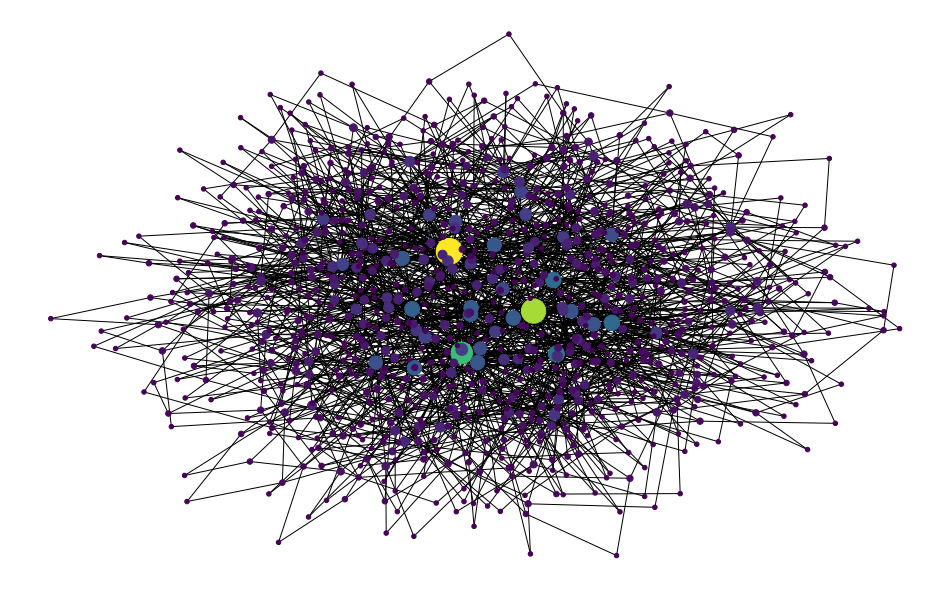

In [182]:
BA = Barabasi_Albert(time_limit = 1000 , m=2)
df = BA.drive_walk(q = 0.74,draw = True)
plt.figure(figsize = (13,8))
BA.draw_knuth(scale = 10)

#### Efficiency Tests

In [499]:
import timeit
import random
np.arange(0,100000,1)
print(timeit.timeit('random.choice(x)', setup = '''
import random 
import numpy as np
x =np.arange(0,1000000,1)''',number=10000))
print(timeit.timeit('np.random.choice(x)', setup = '''
import random 
import numpy as np
x =np.arange(0,1000000,1)''',number=10000))

def get_random_key(a_huge_key_list):
    L = len(a_huge_key_list)
    i = np.random.randint(0, L)
    return a_huge_key_list[i]
print(timeit.timeit('get_random_key(x)', setup = '''
from __main__ import get_random_key
import random 
import numpy as np
x =np.arange(0,1000000,1)''',number=10000))



0.011056135001126677
0.09188798299874179
0.06611339899973245
